# TP1 Visión por Computadora

In [1]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline  
#%matplotlib qt
import numpy as np #
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [2]:
# Función para mostrar imágenes que soporte subplots
def show_images(images, titles=None, cmap='gray'):
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap=cmap)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()


## Parte 1 (imágenes en /white_patch):

### 1. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.

In [3]:
def get_max_pixel_values(image):
    """Devuelve los valores máximos de los canales R, G y B de la imagen."""
    return np.max(image[:, :, 0]), np.max(image[:, :, 1]), np.max(image[:, :, 2])

def apply_gain(image, R_max, G_max, B_max):
    """Aplica la ganancia a cada canal de la imagen según los valores máximos proporcionados."""
    gains = np.array([255.0 / R_max, 255.0 / G_max, 255.0 / B_max])
    corrected = np.clip(image * gains, 0, 255).astype(np.uint8)
    return corrected

def white_patch_correction(image):
    """Aplica la corrección de white patch a la imagen."""

    R_max, G_max, B_max = get_max_pixel_values(image)
    return apply_gain(image, R_max, G_max, B_max)

### 2. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White patch.

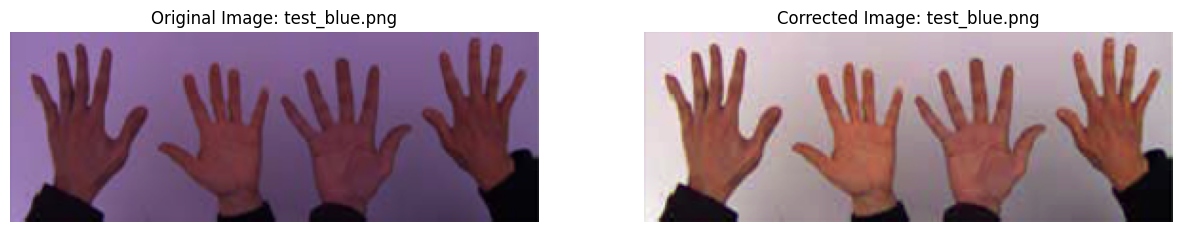

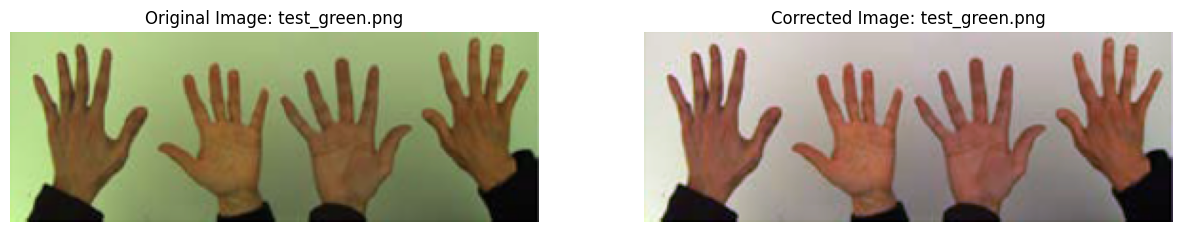

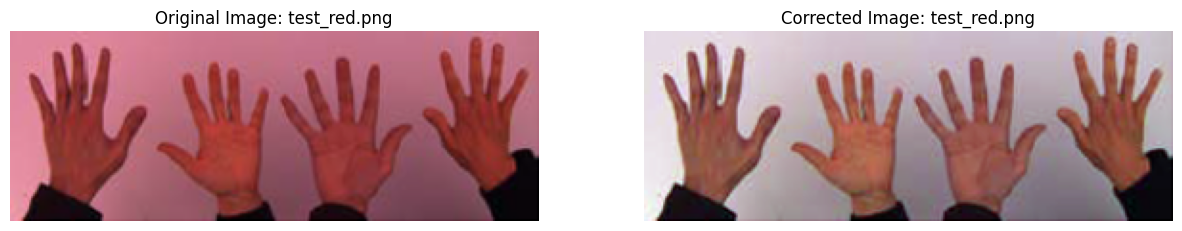

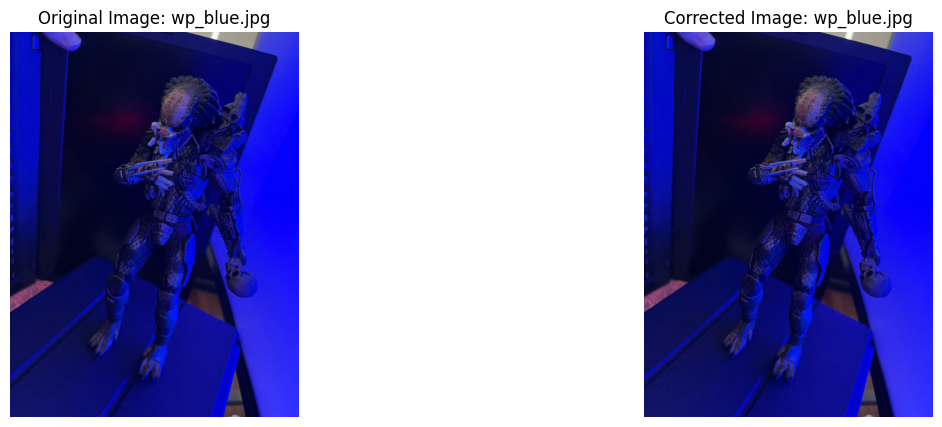

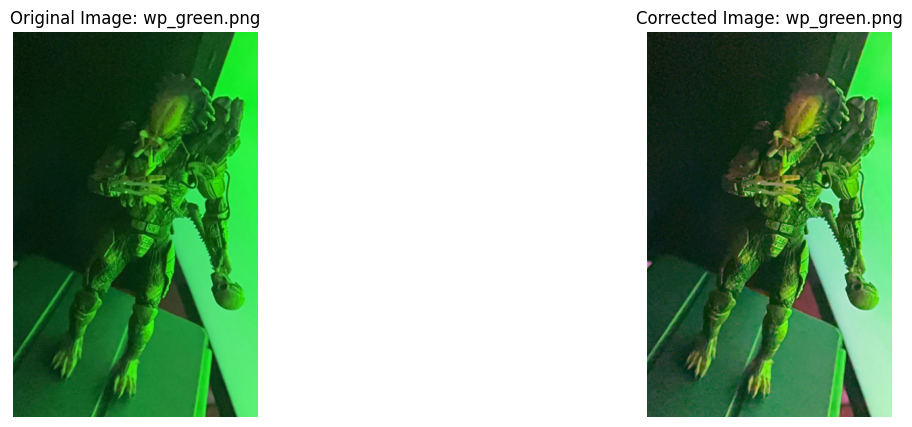

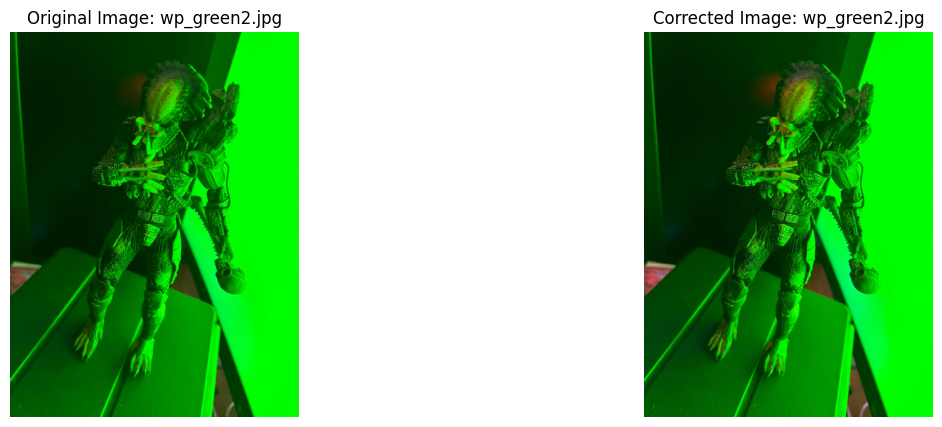

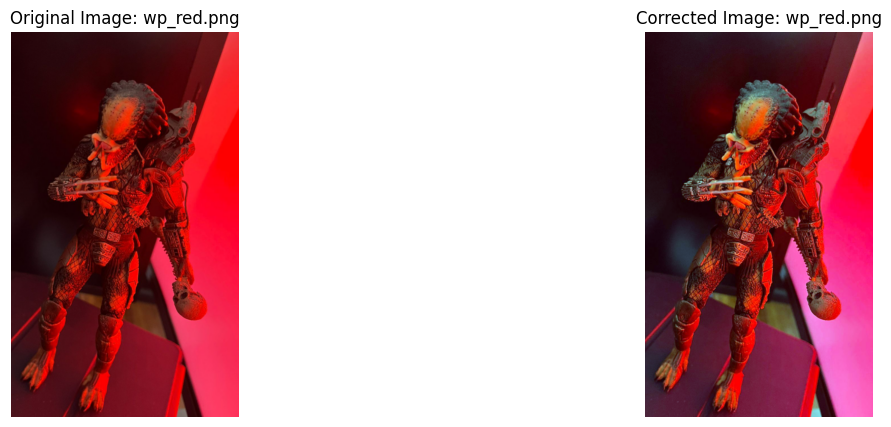

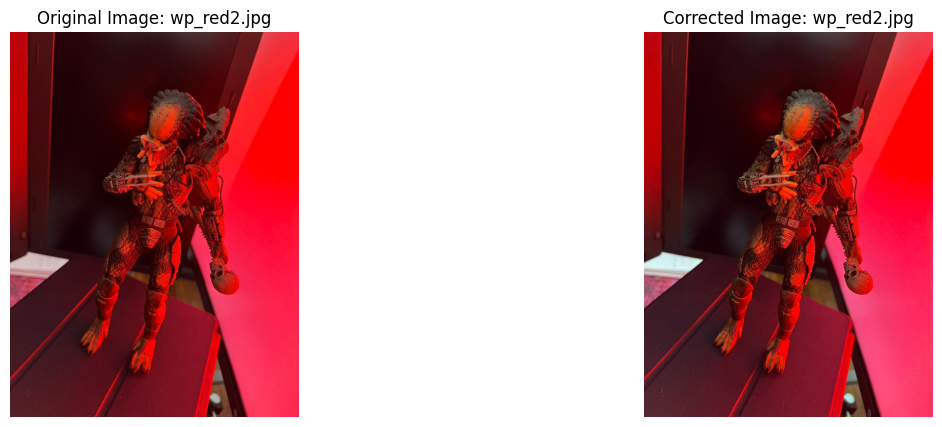

In [4]:
# Procesar todas las imágenes en la carpeta 'white_patch'

for image in sorted(os.listdir('white_patch')):
    if image.endswith('.png') or image.endswith('.jpg'):
        # Leer la imagen
        img = cv.imread(os.path.join('white_patch', image))
        # Convertir de BGR a RGB
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        # Aplicar la corrección de white patch
        corrected_img = white_patch_correction(img)
        
        # Mostrar las imágenes original y corregida
        show_images([img, corrected_img], titles=[f'Original Image: {image}', f'Corrected Image: {image}'])

#### Conclusiones
El algoritmo White Patch se utiliza para la corrección del color en imágenes.
Toma el punto más claro de la imagen, asumiendo que este representa un color blanco verdadero, y utiliza ese valor para ajustar el resto de los píxeles.
A partir del valor máximo en cada canal (R, G, B), el algoritmo calcula una ganancia que se aplica a toda la imagen con el fin de normalizar los niveles de color y obtener una corrección global.

Una de las principales limitaciones del método es el supuesto de que la zona más brillante corresponde efectivamente al blanco, lo que requiere la presencia de un área blanca o neutra en la escena.
En las pruebas realizadas se observa que, cuando la imagen sí contiene zonas blancas, la corrección aplicada es mínima o apenas perceptible.
Sin embargo, en imágenes sin blancos o con reflejos y brillos intensos, el algoritmo puede distorsionar los colores, como se vio en los resultados de las imágenes test_*, donde la corrección fue más efectiva.

Para mejorar su robustez, a veces se reemplaza el valor máximo por un percentil alto (por ejemplo, el 95 %), lo que reduce la influencia de valores atípicos o ruidos.
Por otro lado, el algoritmo tiende a generar saturación, ya que al escalar los canales hasta 255 puede producir pérdida de detalle en las zonas más claras de la imagen.

## Parte 2

### 1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y visualizarlas. 

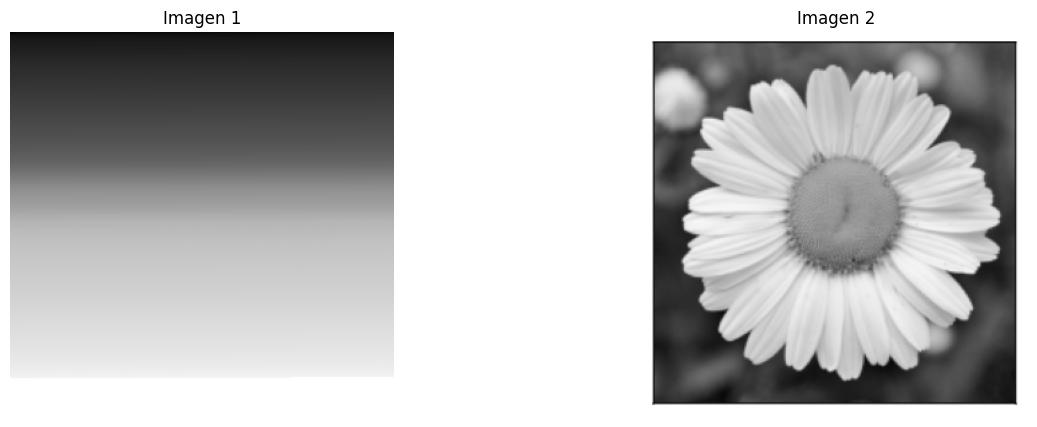

In [5]:
# Cargar las imagenes en escala de grises
img1 = cv.imread('img1_tp.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('img2_tp.png', cv.IMREAD_GRAYSCALE)

# Mostrar las imágenes
show_images([img1, img2], titles=['Imagen 1', 'Imagen 2'])


### 2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘features’ a los histogramas?

In [6]:
def plot_images_with_histograms(images, titles=None, bins_list=[32, 64, 128, 256]):
    """
    Muestra múltiples imágenes en la fila superior y, debajo de cada una, 
    sus histogramas para diferentes números de bins.

    Parámetros
    ----------
    images : list[np.ndarray]
        Lista de imágenes (2D en escala de grises).
    titles : list[str], opcional
        Títulos para cada imagen.
    bins_list : list[int]
        Lista de números de bins para los histogramas.
    """

    n_imgs = len(images)
    n_bins = len(bins_list)

    if titles is None:
        titles = [f'Imagen {i+1}' for i in range(n_imgs)]

    # Crear figura: filas = 1 (imágenes) + len(bins_list)
    fig, axes = plt.subplots(n_bins + 1, n_imgs, figsize=(4 * n_imgs, 3 * (n_bins + 1)))

    # Si solo hay una imagen o un bin, aseguramos que axes sea un array 2D
    axes = np.atleast_2d(axes)

    # --- Fila 1: Imágenes ---
    for j, img in enumerate(images):
        ax = axes[0, j]
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.set_title(titles[j])
        ax.axis('off')

    # --- Filas siguientes: Histogramas ---
    for i, bins in enumerate(bins_list, start=1):
        for j, img in enumerate(images):
            hist, _ = np.histogram(img.ravel(), bins=bins, range=[0, 256])
            ax = axes[i, j]
            ax.plot(hist, color='black')
            ax.set_xlim([0, 256])
            if j == 0:
                ax.set_ylabel(f'{bins} bins')
            if i == n_bins:
                ax.set_xlabel('Nivel de intensidad')

    plt.tight_layout()
    plt.show()


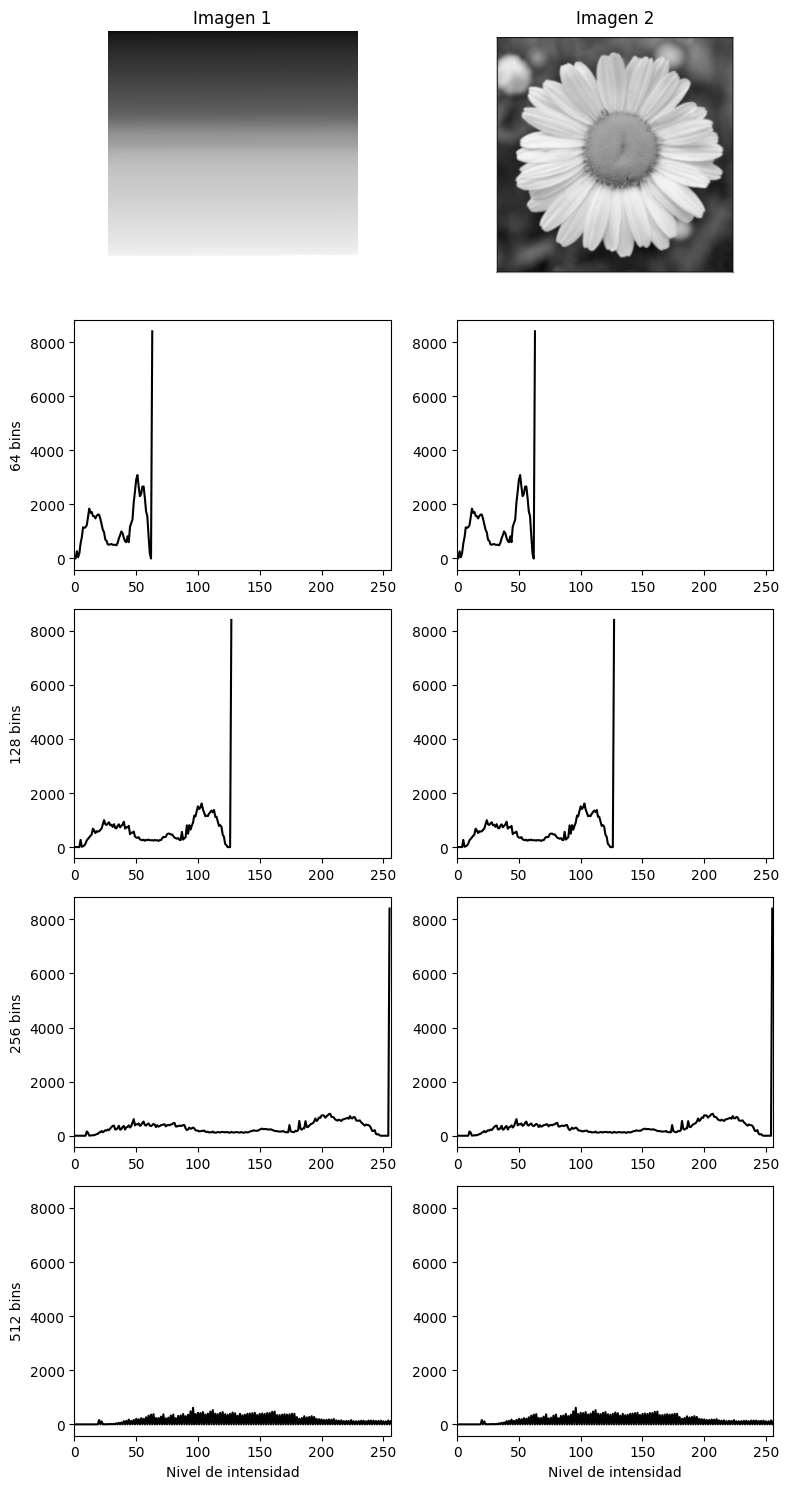

In [7]:
plot_images_with_histograms([img1, img2], bins_list=[64, 128, 256, 512])

#### Conclusiones
Dependiendo del problema que se quiera abordar, se puede elegir una cantidad distinta de bins para el histograma.
En general, para analizar la distribución tonal de una imagen, 256 bins es adecuado, ya que permite representar cada nivel de intensidad posible en una imagen de 8 bits.

Al comparar los histogramas de las dos imágenes, se observa que el de la imagen 2 presenta mucho más ruido. Esto tiene sentido, ya que se trata de una imagen más compleja y heterogénea, con predominancia de ciertos tonos.
En cambio, la imagen 1, que representa un simple gradiente de blanco a negro, genera un histograma más suave y con una distribución uniforme.

El histograma puede utilizarse como descriptor para clasificar imágenes, aunque con limitaciones.
Es útil para tareas de clasificación por color, iluminación o características globales —por ejemplo, distinguir entre un bosque y un desierto—, pero no es suficiente para detectar objetos específicos, ya que no conserva información espacial sobre dónde se encuentran los tonos en la imagen.